# Word2Vec models comparison

We compare the different models of word2vec against different intrinsic word embeddings tasks.

**BLUNDER: all 200 and 300 D models are not trained on leema text**

### Import and load datasets

In [ ]:
# imports
!pip install ray[tune]
import ray
from ray.tune.utils import pin_in_object_store, get_pinned_object
ray.init(ignore_reinit_error=True)
import pickle
import time
from numpy.linalg import norm
from scipy.spatial.distance import cosine, cdist
import base64
!pip install telepot
import telepot

!pip install nltk
import nltk
nltk.download('wordnet')
import glob
!pip install tqdm
from tqdm import tqdm
import pandas as pd
!pip install gensim
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

     |████████████████████████████████| 308 kB 6.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
2020-09-12 17:20:39,921	INFO resource_spec.py:231 -- Starting Ray with 3.91 GiB memory available for workers and up to 1.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-12 17:20:40,896	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2020-09-12 17:20:40,907	WARNING services.py:1567 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2020-09-12 17:20:40,948	WARNING services.py:1567 -- WARNING: The object store is

In [ ]:
## Load telepot
def send_telegram_message(message):
    token = '1361671158:AAF9jfW_fT0aF0zHwHtpOaUEB9CPYhmyew8'
    TelegramBot = telepot.Bot(token)
    TelegramBot.sendMessage(934022573, str(message))

In [ ]:
# send_telegram_message("test from deepnotes")

In [ ]:
with open ("../data/all_datasets.pickle", 'rb') as f:
    all_datasets = pickle.load(f)

In [ ]:
# all([len(set(x))==4 for x in all_datasets['analogy_datasets']['bats_analogy']])
# all_datasets['analogy_datasets']['bats_analogy'][:10]
# for x , y in all_datasets['relatedness_datasets'].items():
#     print(x, len(y))

### Load word2vec models

In [ ]:
def nnorm(matrix):
    "norm each vector in the matrix"
    return (matrix.T/norm(matrix, axis=1)).T
    
model = Word2Vec.load("../../../embeddings_lemma/word2vec_mc=10_iter=5_size=200_window=5_sg=0/word2vec_wikiEn20171001_millionSentences_mc=10_iter=5_size=200_window=5_sg=0")
model.wv.vectors = nnorm(model.wv.vectors) 
model.trainables.syn1neg = nnorm(model.trainables.syn1neg)


### Create Word2vec similarity computing method

In [ ]:
def word2vec_get_index_by_word(word2vec_model, word):
    """Return the index of the word in the model
    """
    return word2vec_model.wv.index2word.index(word)

def word2vec_get_word_by_index(word2vec_model, index):
    """Return the word by the provided index
    """
    return word2vec_model.wv.index2word[index]

def word2vec_get_model_matrix_by_method(word2vec_model, method):
    """Return the source and compare matrix based on model and method selection
    """
    input_weights = word2vec_model.wv.vectors
    output_weights = word2vec_model.trainables.syn1neg
    weights1, weights2 = None, None
    if method=="IN-IN":
        weights1, weights2 = input_weights, input_weights 
    elif method=="IN-OUT":
        weights1, weights2 = input_weights, output_weights
    elif method=="OUT-IN":
        weights1, weights2 = output_weights, input_weights
    elif method=="OUT-OUT":
        weights1, weights2 = output_weights, output_weights
    return weights1, weights2

def word2vec_find_top_similar_vectors_bw_matrix(vector, compare_matrix, source_word_index, index2word, top_n=5, no_self_similarity=True):
    """Find top n similar vectors in the compare matrix
    """
    score = np.dot(vector, compare_matrix)[0]
    if no_self_similarity:
        score[source_word_index] = -1 # negate self-similarity
    top_n_similar_words = np.argpartition(-score, top_n)[:top_n]
    sorted_result = sorted([(index2word[index], score[index]) for index in top_n_similar_words], 
                key=lambda x: x[1], 
                reverse=True)
    return sorted_result

def word2vec_find_top_similar_words(word2vec_model, source_word, method='IN-IN', top_n=5, no_self_similarity=True):
    """
    Provided a word, find the top_n most similar from the model following the method
    """
    score = []
    source_word_index = word2vec_get_index_by_word(word2vec_model, source_word)
    source_matrix, compare_matrix = word2vec_get_model_matrix_by_method(word2vec_model, method)
    sorted_result = word2vec_find_top_similar_vectors_bw_matrix(
            vector=source_matrix[source_word_index].reshape(1, -1),
            compare_matrix=compare_matrix.T, 
            source_word_index = source_word_index,
            index2word=word2vec_model.wv.index2word,
            top_n=top_n, 
            no_self_similarity=no_self_similarity)
    return sorted_result

def word2vec_find_similarity(word2vec_model, source_word, target_word, method="IN-IN"):
    """Return the cosine similarity between two words based on the suggested method
    """
    source_word_index = word2vec_get_index_by_word(word2vec_model, source_word)
    target_word_index = word2vec_get_index_by_word(word2vec_model, target_word)
    source_matrix, compare_matrix = word2vec_get_model_matrix_by_method(word2vec_model, method)
    score = cosine_similarity(source_matrix[source_word_index].reshape(1, -1), 
                              compare_matrix[target_word_index].reshape(1, -1))[0]
    return score

# word2vec_find_similarity(model, "car", "truck", "IN-OUT")
# word2vec_find_top_similar_words(model, "car", "IN-IN")
# word2vec_find_top_similar_words(model, "car", "IN-OUT")

# lemmatizer - noun lemma -- https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word
def lemma(word): return nltk.stem.WordNetLemmatizer().lemmatize(word)

# preprocss the word - lowercase and lemma
def pre(word): return lemma(word.lower())

In [ ]:
# word2vec_find_top_similar_words(get_pinned_object(model), 'car', method='IN-IN', top_n=10, no_self_similarity=True)

## Test functions

In [ ]:
glob_w2v_models = ['../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=5_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=5_sg=1',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=50_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=50_sg=1',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=200_window=5_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=200_window=5_sg=1',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=200_window=50_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=200_window=50_sg=1',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=300_window=5_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=300_window=5_sg=1',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=300_window=50_sg=0',
                    '../../../embeddings_lemma/word2vec_mc=10_iter=5_size=300_window=50_sg=1']

# @ray.remote
def compare_word2vec_model_with_relatedness_dataset(model, model_name, dataset_name, dataset):
    missing_words = 0
    score_table = []
    for row in dataset.to_dict(orient="records"):
        methods = ["IN-IN", "IN-OUT", "OUT-IN", "OUT-OUT"]
        for method in methods:
            try:
                sim_score = word2vec_find_similarity(model, pre(row['word_1']), pre(row['word_2']), method)[0]
            except:
                sim_score = None
                missing_words += 1
            row[f"{model_name}_{method}"] = sim_score
        score_table.append(row)
    score_table = pd.DataFrame.from_dict(score_table)
    score_table = score_table.dropna().corr("pearson")[['similarity_score']].tail(4)
    score_table.columns = [dataset_name]
    missing_words = missing_words/len(methods)
    return score_table, dataset_name, missing_words

def calculate_tp_score(y_pred, y_true):
    y_pred, y_true = set(y_pred), set(y_true)
    tp = y_pred & y_true
    # fp = y_pred - tp
    # tn = 0.001
    # fn = y_true - y_pred
    # precision = len(tp) / (len(tp) + len(fp))
    # recall = len(tp) / (len(tp) + len(fn))
    # try:
    #     f1_score = 2*(precision * recall)/(precision + recall)
    # except ZeroDivisionError:
    #     f1_score = 0
    return len(tp)/len(y_true)

def word2vec_check_all_word_in_model(words, index2word):
    return all([word in index2word for word in words])

@ray.remote
def word2vec_test_association_dataset(model, model_name, dataset_name, dataset):
    # word2vec_model = get_pinned_object(model)
    word2vec_model = model
    possible_top_n = [10]
    methods = ["IN-IN", "IN-OUT", "OUT-IN", "OUT-OUT"]
    max_possible_top_n = max(possible_top_n)
    all_cue_test_result= []
    for cue_name, cue_data in dataset.groupby(['cue']):
        expected_responses = cue_data['response'].values
        if not word2vec_check_all_word_in_model([cue_name] + list(expected_responses), word2vec_model.wv.index2word):
            continue
        cue_test_result = {'cue': cue_name, 'expected_responses': expected_responses}
        for method in methods:
            model_response = word2vec_find_top_similar_words(word2vec_model, cue_name, method, top_n=max_possible_top_n)
            for top_n in possible_top_n:
                subset_model_response = [x[0] for x in model_response[:top_n]]
                tp_score = calculate_tp_score(subset_model_response, expected_responses)
                model_method_topn_name = f'{model_name}_{method}_{top_n}'
                cue_test_result[f'{model_method_topn_name}_model_response'] = subset_model_response
                cue_test_result[f'{model_method_topn_name}_tp_score'] = tp_score
        all_cue_test_result.append(cue_test_result)
    return dataset_name, all_cue_test_result

## 
# ANALGOY
##
def cos3mul(compare_matrix, word_index, a, a_s, b,  b_s, top_n, e=0.0000001):
    """From: https://www.aclweb.org/anthology/W14-1618.pdf; Page 175
    """
    c = np.stack([b, a_s, a], axis=1)
    all_scores = np.dot(compare_matrix, c)
    all_scores = (all_scores + 1)/2 # normalize bw 0 to 1
    all_scores[:, 2] += e
    all_scores = ((all_scores[:, 0] * all_scores[:, 1]) / all_scores[:, 2])
    top_n_similar_words = np.argpartition(-all_scores, top_n)[:top_n]
    sorted_result = sorted([(word_index[index], all_scores[index]) for index in top_n_similar_words], 
                key=lambda x: x[1], 
                reverse=True)
    sorted_result = [x[0] for x in sorted_result]
    return sorted_result, 1 if b_s in sorted_result else 0

def cos3add(compare_matrix, a, a_s, b, b_s, top_n, index2word):
    """Find the most similar vector with (b-a+a_)
    """
    b_ = b.reshape(1, -1)-a.reshape(1, -1)+a_s.reshape(1, -1)
    res = word2vec_find_top_similar_vectors_bw_matrix(
            b_, compare_matrix, None, index2word, top_n=top_n, no_self_similarity=False)
    res = [x[0] for x in res]
    return res, 1 if b_s in res else 0

# for dataset_name, dataset in all_datasets['analogy_datasets'].items():
    # dataset_result = []
@ray.remote
def word2vec_test_analogy_dataset(model, model_name, dataset_name, dataset):
    dataset_result = []
    # word2vec_model = get_pinned_object(model)
    word2vec_model = model
    for row in dataset:
        a, a_s, b, b_s = row
        try:
            a_index = word2vec_get_index_by_word(word2vec_model, a)
            a_s_index = word2vec_get_index_by_word(word2vec_model, a_s)
            b_index = word2vec_get_index_by_word(word2vec_model, b)
            b_s_index = word2vec_get_index_by_word(word2vec_model, b_s)
        except:
            continue
        for method in ["IN-IN", "IN-OUT", "OUT-IN", "OUT-OUT"]:
            source_matrix, compare_matrix = word2vec_get_model_matrix_by_method(word2vec_model, method)
            a_vector = source_matrix[a_index]
            a_s_vector = source_matrix[a_s_index]
            b_vector = source_matrix[b_index]
            cos3add_response, cos3add_score = \
                cos3add(compare_matrix.T, a_vector, a_s_vector, b_vector, b_s, 3, word2vec_model.wv.index2word)
            cos3mul_response, cos3mul_score = \
                cos3mul(compare_matrix, word2vec_model.wv.index2word, a_vector, a_s_vector, b_vector, b_s, top_n=3)
            dataset_result.append({
                'analogy': row,
                'method': method, 
                'model': model_name,
                'cos3add_response': cos3add_response,
                'cos3add_score': cos3add_score,
                'cos3mul_response': cos3mul_response,
                'cos3mul_score': cos3mul_score
            })
    return dataset_name, pd.DataFrame(dataset_result)

In [ ]:
# ['car', 'truck'] not in get_pinned_object(model).wv.index2word
# all([True, False, True])
# [5] + [1,2,3]

## Run Analogy

In [ ]:
# perform this for each model
for model_dir in tqdm(glob_w2v_models[3:]):
    model_name = model_dir.replace("../../../embeddings_lemma/", "").replace("iter=5_", "")
    model_path = glob.glob(model_dir + "/*[!(npy)]")[0]
    model = Word2Vec.load(model_path)
    model.wv.vectors = nnorm(model.wv.vectors) 
    model.trainables.syn1neg = nnorm(model.trainables.syn1neg)
    # model = pin_in_object_store(model)
    # print("Running analysis on each dataset")
    # Step 1: Handle relatedness dataset
    futures = [word2vec_test_analogy_dataset.remote(model, model_name, dataset_name, dataset) \
                    for dataset_name, dataset in all_datasets['analogy_datasets'].items()]
    res = ray.get(futures)    
    # print("Post processing and Saving results")
    # pd.concat(res, axis=1)
    df_res = {dname:df_res for dname, df_res in res}
    with open(f"../output/word2vec/analogy/word2vec_results_{model_name}_analogy.pickle", "wb") as f:
        pickle.dump({"score_matrix": df_res}, f)
    # clean ray object store
    # ray.internal.free(model)
    # message from telegram
    try:
        send_telegram_message(model_name)
        send_telegram_message(str(df_res['google_analogy'].groupby('method').mean()))
        send_telegram_message(str(df_res['bats_analogy'].groupby('method').mean()))
    except:
        pass
                

 67%|██████▋   | 6/9 [2:47:33<1:28:26, 1768.90s/it]

100%|██████████| 9/9 [4:46:47<00:00, 1911.90s/it]  


In [ ]:
# glob.glob("../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=5_sg=0/*")
import pickle
with open("../output/word2vec/analogy/word2vec_results_word2vec_mc=10_size=100_window=5_sg=0_analogy.pickle", "rb") as f:
    _ = pickle.load(f)
# _['score_matrix'][0]
(_['score_matrix']['bats_analogy'].groupby('method').mean())
# _['score_matrix']['google_analogy'].query('method=="IN-OUT"')

,cos3add_score,cos3mul_score
method,,
IN-IN,0.272093,0.230233
IN-OUT,0.153488,0.151163
OUT-IN,0.000000,0.000000
OUT-OUT,0.206977,0.204651


'listens'

## Run Relatedness tests

In [ ]:
# all_df_res = []
# all_missing_words = []

# perform this for each model
# for model_dir in tqdm(glob.glob("../../../embeddings_lemma/word2vec_*")[3:]):
for model_dir in tqdm(glob_w2v_models):
    model_name = model_dir.replace("../../../embeddings_lemma/", "").replace("iter=5_", "")
    model_path = glob.glob(model_dir + "/*[!(npy)]")[0]
    model = Word2Vec.load(model_path)
    model.wv.vectors = nnorm(model.wv.vectors) 
    model.trainables.syn1neg = nnorm(model.trainables.syn1neg)
    # print("Running analysis on each dataset")
    # Step 1: Handle relatedness dataset
    futures = [compare_word2vec_model_with_relatedness_dataset.remote(model, model_name, dataset_name, dataset) \
                    for dataset_name, dataset in all_datasets['relatedness_datasets'].items()]
    res = ray.get(futures)    
    # print("Post processing and Saving results")
    # pd.concat(res, axis=1)
    df_res = pd.concat([df_res for df_res, _, _ in res], axis=1)
    missing_words = {key:val for _, key, val in res}
    # all_df_res.append(df_res)
    # all_missing_words.append(missing_words)
    with open(f"../output/word2vec/relatedness/word2vec_results_{model_name}_relatedness.pickle", "wb") as f:
        pickle.dump({"score_matrix": df_res, 'missing_words': missing_words}, f)
    try:
        send_telegram_message(model_name)
        send_telegram_message(str(df_res.iloc[:, [0]]))
    except:
        pass

  0%|          | 0/12 [00:00<?, ?it/s](pid=raylet) E0901 19:52:15.305629   218   233 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008004000000, data_size=769881459, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
2020-09-01 19:52:19,004	INFO (unknown file):0 -- gc.collect() freed 16 refs in 3.551877399906516 seconds
(pid=raylet) E0901 19:52:16.324450   218   233 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008004000000, data_size=769881459, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=249) 2020-09-01 19:52:16,983	INFO (unknown file):0 -- gc.collect() freed 7 refs in 1.5036049876362085 seconds
(pid=raylet) E0901 19:52:18.325723   218   233 store.cc:252] Not enough memory to create the object ffffffffffffffffffffffff0100008004000000, data_size=769881459, metadata_size=6, will send a reply of PlasmaError::OutOfMemory
(pid=raylet) E0901 19:52:22.326722   218   233 store.cc:252] Not

ObjectStoreFullError: Failed to put object ffffffffffffffffffffffff0100008006000000 in object store because it is full. Object size is 769881459 bytes.
The local object store is full of objects that are still in scope and cannot be evicted. Try increasing the object store memory available with ray.init(object_store_memory=<bytes>). You can also try setting an option to fallback to LRU eviction when the object store is full by calling ray.init(lru_evict=True). See also: https://docs.ray.io/en/latest/memory-management.html.

In [ ]:
## NO RAY version

# perform this for each model
# for model_dir in tqdm(glob.glob("../../../embeddings_lemma/word2vec_*")[3:]):
for model_dir in tqdm(glob_w2v_models):
    model_name = model_dir.replace("../../../embeddings_lemma/", "").replace("iter=5_", "")
    model_path = glob.glob(model_dir + "/*[!(npy)]")[0]
    model = Word2Vec.load(model_path)
    model.wv.vectors = nnorm(model.wv.vectors) 
    model.trainables.syn1neg = nnorm(model.trainables.syn1neg)
    # print("Running analysis on each dataset")
    # Step 1: Handle relatedness dataset
    all_df_res = []
    for dataset_name, dataset in all_datasets['relatedness_datasets'].items():
        df_res = compare_word2vec_model_with_relatedness_dataset(model, model_name, dataset_name, dataset)
        all_df_res.append(df_res)
    with open(f"../output/word2vec/relatedness/word2vec_results_{model_name}_relatedness.pickle", "wb") as f:
        pickle.dump({"score_matrix": all_df_res}, f)
    try:
        send_telegram_message(model_name)
        send_telegram_message(str(df_res.iloc[:, [0]]))
    except:
        pass

100%|██████████| 12/12 [3:16:39<00:00, 983.28s/it]  


In [ ]:
# glob.glob("../../../embeddings_lemma/word2vec_mc=10_iter=5_size=100_window=5_sg=0/*")
import pickle
with open("../output/word2vec/word2vec_results_word2vec_mc=10_size=100_window=5_sg=0_relatedness.pickle", "rb") as f:
    _ = pickle.load(f)
_['score_matrix'][0]

,EN-VERB-143,EN-SimVerb-3500,EN-RG-65,EN-RW-STANFORD,EN-MTurk-771,EN-MEN-TR-3k,EN-MC-30,EN-MTurk-287,EN-SIMLEX-999,EN-WS-353-REL,EN-YP-130,EN-WS-353-ALL,EN-WS-353-SIM
word2vec_mc=10_size=100_window=5_sg=0_IN-IN,0.397469,0.217320,0.733976,0.399236,0.658790,0.720543,0.788112,0.714405,0.377482,0.554434,0.396154,0.629383,0.720831
word2vec_mc=10_size=100_window=5_sg=0_IN-OUT,0.204517,0.141380,0.801957,0.155526,0.656008,0.764957,0.832302,0.657793,0.280067,0.636703,0.443034,0.670449,0.729736
word2vec_mc=10_size=100_window=5_sg=0_OUT-IN,0.271551,0.144981,0.798610,0.235247,0.647450,0.766770,0.823056,0.679873,0.262355,0.631646,0.463202,0.663323,0.725765
word2vec_mc=10_size=100_window=5_sg=0_OUT-OUT,0.260214,0.196653,0.605548,0.414003,0.497709,0.590263,0.688151,0.529687,0.324987,0.475809,0.300444,0.551615,0.604563


## Run association test

In [ ]:
all_datasets['association_datasets'].keys()

dict_keys(['swow8500', 'eat'])

In [ ]:

# perform this for each model
# for model_dir in tqdm(glob.glob("../../../embeddings_lemma/word2vec_*")[3:]):
for model_dir in tqdm(glob_w2v_models):
    model_name = model_dir.replace("../../../embeddings_lemma/", "").replace("iter=5_", "")
    model_path = glob.glob(model_dir + "/*[!(npy)]")[0]
    model = Word2Vec.load(model_path)
    model.wv.vectors = nnorm(model.wv.vectors) 
    model.trainables.syn1neg = nnorm(model.trainables.syn1neg)
    # model = pin_in_object_store(model)
    # print("Running analysis on each dataset")
    # Step 1: Handle relatedness dataset
    futures = [word2vec_test_association_dataset.remote(model, model_name, dataset_name, dataset) \
                    for dataset_name, dataset in all_datasets['association_datasets'].items()]
    res = ray.get(futures)    
    # print("Post processing and Saving results")
    # pd.concat(res, axis=1)
    df_res = {dname:df_res for dname, df_res in res}
    with open(f"../output/word2vec/association/word2vec_results_{model_name}_association.pickle", "wb") as f:
        pickle.dump({"score_matrix": df_res}, f)
    try:
        send_telegram_message(model_name)
    except:
        pass

100%|██████████| 12/12 [11:05:23<00:00, 3326.95s/it] 


## Test Analogy

In [ ]:
# all_datasets['analogy_datasets']['google_analogy'][:]
def cos3mul(compare_matrix, word_index, a, a_s, b,  b_s, top_n, e=0.0000001):
    c = np.stack([b, a_s, a], axis=1)
    all_scores = np.dot(compare_matrix, c)
    all_scores = (all_scores + 1)/2 # normalize bw 0 to 1
    all_scores[:, 2] += e
    all_scores = ((all_scores[:, 0] * all_scores[:, 1]) / all_scores[:, 2])
    top_n_similar_words = np.argpartition(-all_scores, top_n)[:top_n]
    sorted_result = sorted([(word_index[index], all_scores[index]) for index in top_n_similar_words], 
                key=lambda x: x[1], 
                reverse=True)
    sorted_result = [x[0] for x in sorted_result]
    return sorted_result, 1 if b_s in sorted_result else 0

def cos3add(compare_matrix, a, a_s, b, b_s, top_n, index2word):
    """Find the most similar vector with (b-a+a_)
    """
    b_ = b.reshape(1, -1)-a.reshape(1, -1)+a_s.reshape(1, -1)
    res = word2vec_find_top_similar_vectors_bw_matrix(
            b_, compare_matrix, None, index2word, top_n=top_n, no_self_similarity=False)
    res = [x[0] for x in res]
    return res, 1 if b_s in res else 0

# for dataset_name, dataset in all_datasets['analogy_datasets'].items():
    # dataset_result = []
@ray.remote
def word2vec_test_analogy_dataset(model_name, dataset, dataset_name):
    word2vec_model = get_pinned_object(model)
    for row in tqdm(dataset):
        a, a_s, b, b_s = row
        try:
            a_index = word2vec_get_index_by_word(word2vec_model, a)
            a_s_index = word2vec_get_index_by_word(word2vec_model, a_s)
            b_index = word2vec_get_index_by_word(word2vec_model, b)
            b_s_index = word2vec_get_index_by_word(word2vec_model, b_s)
        except:
            continue
        for method in ["IN-IN", "IN-OUT", "OUT-IN", "OUT-OUT"]:
            source_matrix, compare_matrix = word2vec_get_model_matrix_by_method(word2vec_model, method)
            a_vector = source_matrix[a_index]
            a_s_vector = source_matrix[a_s_index]
            b_vector = source_matrix[b_index]
            cos3add_response, cos3add_score = \
                cos3add(compare_matrix.T, a_vector, a_s_vector, b_vector, b_s, 3, word2vec_model.wv.index2word)
            cos3mul_response, cos3mul_score = \
                cos3mul(compare_matrix, word2vec_model.wv.index2word, a_vector, a_s_vector, b_vector, b_s, top_n=3)
            dataset_result.append({
                'analogy': row,
                'method': method, 
                'cos3add_response': cos3add_response,
                'cos3add_score': cos3add_score,
                'cos3mul_response': cos3mul_response,
                'cos3mul_score': cos3mul_score
            })
    return dataset_name, pd.DataFrame(dataset_result)

# perform this for each model
for model_dir in tqdm(glob_w2v_models):
    model_name = model_dir.replace("../../../embeddings_lemma/", "").replace("iter=5_", "")
    model_path = glob.glob(model_dir + "/*[!(npy)]")[0]
    model = Word2Vec.load(model_path)
    model.wv.vectors = nnorm(model.wv.vectors) 
    model.trainables.syn1neg = nnorm(model.trainables.syn1neg)
    model = pin_in_object_store(model)
    # print("Running analysis on each dataset")
    # Step 1: Handle relatedness dataset
    futures = [word2vec_test_association_dataset.remote(model_name, dataset_name, dataset) \
                    for dataset_name, dataset in all_datasets['analogy_datasets'].items()]
    res = ray.get(futures)    
    # print("Post processing and Saving results")
    # pd.concat(res, axis=1)
    df_res = {dname:df_res for dname, df_res in res}
    with open(f"../output/word2vec_results_{model_name}_analogy.pickle", "wb") as f:
        pickle.dump({"score_matrix": df_res}, f)
                

  3%|▎         | 27/994 [00:15<09:04,  1.78it/s]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(dataset_result)

,analogy,method,cos3add_response,cos3add_score,cos3mul_response,cos3mul_score
0,"[rome, italy, islamabad, pakistan]",IN-IN,"[islamabad, malaysia, ===pakistan===]",0,"[===pakistan===, ====pakistan====, malaysia]",0
1,"[rome, italy, islamabad, pakistan]",IN-OUT,"[pakistan, malaysia, iran]",1,"[pakistan, malaysia, bangladesh]",1
2,"[rome, italy, islamabad, pakistan]",OUT-IN,"[aa/semitic, petrochimi, tejan-sie]",0,"[aa/semitic, petrochimi, tejan-sie]",0
3,"[rome, italy, islamabad, pakistan]",OUT-OUT,"[islamabad, pakistan, sargodha]",1,"[pakistan, islamabad, gilgit-baltistan]",1
4,"[hanoi, vietnam, canberra, australia]",IN-IN,"[canberra, queensland, australian]",0,"[queensland, australian, nsw]",0
...,...,...,...,...,...,...
105,"[bangkok, thailand, canberra, australia]",IN-OUT,"[australia, canberra, ===australia===]",1,"[australia, ===australia===, canberra]",1
106,"[bangkok, thailand, canberra, australia]",OUT-IN,"[aa/semitic, hmts, forceably]",0,"[aa/semitic, hmts, forceably]",0
107,"[bangkok, thailand, canberra, australia]",OUT-OUT,"[canberra, queensland, tasmania]",0,"[canberra, queensland, tasmania]",0
108,"[madrid, spain, athens, greece]",IN-IN,"[greece, athens, peloponnesus]",1,"[greece, colchis, athens]",1


In [ ]:
# # all_datasets['analogy_datasets']['google_analogy']['gram8-plural'][:10]
# # all_datasets['analogy_datasets']['bats_analogy'][:10]
# # pd.DataFrame(dataset_result)
# def cos3mul(compare_matrix, word_index, c,  b_s, top_n, e=0.0000001):
#     all_scores = np.dot(compare_matrix, c)
#     all_scores = (all_scores + 1)/2 # normalize bw 0 to 1
#     all_scores[:, 2] += e
#     all_scores = ((all_scores[:, 0] * all_scores[:, 1]) / all_scores[:, 2])
#     top_n_similar_words = np.argpartition(-all_scores, top_n)[:top_n]
#     sorted_result = sorted([(word_index[index], all_scores[index]) for index in top_n_similar_words], 
#                 key=lambda x: x[1], 
#                 reverse=True)
#     sorted_result = [x[0] for x in sorted_result]
#     return sorted_result, 1 if b_s in sorted_result else 0
# # test
# # source_matrix, compare_matrix = word2vec_get_model_matrix_by_method(model, "IN-IN")
# # c = np.stack(
# #     [source_matrix[word2vec_get_index_by_word(model, 'tehran')],
# #     source_matrix[word2vec_get_index_by_word(model, 'italy')],
# #     source_matrix[word2vec_get_index_by_word(model, 'rome')]]
# #         , axis=1)
# # cos3mul(compare_matrix, model.wv.index2word, c,  'pakistan', 10, e=0.0001)

(['iran',
  'tehran',
  '===iran===',
  'azerbaijan',
  'khodro',
  'utc+03:30',
  'kuwait',
  'abadan',
  'uae',
  'bahrain'],
 0)

In [ ]:
# np.stack([[1, 0], [1, 1], [0, 1]], axis=1)
# all_dataset
# model.wv.most_similar(positive=['italy', 'islamabad'], negative=['rome'])
# ais = np.dot(compare_matrix, c)
# max(((ais[:, 0] * ais[:, 1])/(ais[:, 2]+0.001)))#[1951]
ais.min()

-0.4604089

In [ ]:
# print(model.wv.index2word.index('pakistan'))
all_datasets['analogy_datasets']['google_analogy'][:10]

[['rome', 'italy', 'islamabad', 'pakistan'],
 ['hanoi', 'vietnam', 'canberra', 'australia'],
 ['ottawa', 'canada', 'havana', 'cuba'],
 ['stockholm', 'sweden', 'london', 'england'],
 ['havana', 'cuba', 'berlin', 'germany'],
 ['athens', 'greece', 'tehran', 'iran'],
 ['cairo', 'egypt', 'canberra', 'australia'],
 ['tokyo', 'japan', 'helsinki', 'finland'],
 ['islamabad', 'pakistan', 'hanoi', 'vietnam'],
 ['islamabad', 'pakistan', 'paris', 'france']]

## Combine all results

### Relatedness

In [ ]:
# Load all relatedness results
all_relatedness_table = []
for result_file in glob.glob("../output/word2vec/relatedness/*"):
    with open (result_file, "rb") as f:
        data = pickle.load(f)
        table = pd.concat([x[0] for x in data['score_matrix']], axis=1)
        all_relatedness_table.append(table)    
        # print(result_file)
all_relatedness_table = pd.concat(all_relatedness_table)
all_relatedness_table.to_csv("../output/all_relatedness_table_v2.csv")

In [ ]:
# all_relatedness_table.index
# np.allclose(all_relatedness_table[3].values, all_relatedness_table[10].values)
# pd.concat(all_relatedness_table)
# all_relatedness_table[10].index
# with open (glob.glob("../output/word2vec/relatedness/*")[0], "rb") as f:
#     data = pickle.load(f)
# pd.concat([x[0] for x in data['score_matrix']], axis=1)
all_relatedness_table


,EN-VERB-143,EN-SimVerb-3500,EN-RG-65,EN-RW-STANFORD,EN-MTurk-771,EN-MEN-TR-3k,EN-MC-30,EN-MTurk-287,EN-SIMLEX-999,EN-WS-353-REL,EN-YP-130,EN-WS-353-ALL,EN-WS-353-SIM
word2vec_mc=10_size=200_window=50_sg=1_IN-IN,0.348385,0.136442,0.689558,0.371992,0.600273,0.705429,0.748075,0.697174,0.250338,0.576391,0.404015,0.617125,0.680832
word2vec_mc=10_size=200_window=50_sg=1_IN-OUT,0.235017,0.155150,0.692447,0.321379,0.576795,0.705933,0.676273,0.681006,0.244184,0.601608,0.417910,0.637686,0.696694
word2vec_mc=10_size=200_window=50_sg=1_OUT-IN,0.241199,0.134027,0.699191,0.342025,0.570744,0.707308,0.774847,0.686461,0.212156,0.606514,0.358022,0.639168,0.701967
word2vec_mc=10_size=200_window=50_sg=1_OUT-OUT,0.200181,0.120344,0.662345,0.353782,0.521671,0.655967,0.705394,0.663086,0.258613,0.478582,0.264028,0.562823,0.643725
word2vec_mc=10_size=300_window=5_sg=1_IN-IN,0.517928,0.227086,0.788407,0.434912,0.648054,0.744061,0.834629,0.703733,0.345374,0.613786,0.496736,0.665041,0.760809
word2vec_mc=10_size=300_window=5_sg=1_IN-OUT,0.299097,0.199233,0.807674,0.349348,0.646708,0.754456,0.780756,0.691210,0.316901,0.633388,0.595605,0.681078,0.756384
word2vec_mc=10_size=300_window=5_sg=1_OUT-IN,0.292260,0.195872,0.794775,0.376885,0.635240,0.756149,0.825204,0.690761,0.307551,0.638189,0.567946,0.684379,0.762446
word2vec_mc=10_size=300_window=5_sg=1_OUT-OUT,0.393531,0.227743,0.791328,0.445182,0.609784,0.707830,0.828334,0.685684,0.352648,0.585010,0.407597,0.642707,0.731489
word2vec_mc=10_size=200_window=50_sg=0_IN-IN,0.394430,0.242295,0.810194,0.416176,0.673047,0.748357,0.827492,0.729598,0.384130,0.617595,0.549107,0.682406,0.770362
word2vec_mc=10_size=200_window=50_sg=0_IN-OUT,0.364491,0.217746,0.806325,0.174929,0.675458,0.767482,0.850240,0.688254,0.328275,0.679162,0.628606,0.722037,0.797995


dict_keys(['score_matrix'])

### Association

In [ ]:
# all association result
def clean_association_model_name(name): return name.replace("mc=10_", "").replace("_10_tp_score", "")
all_association_result = []
for result_file in tqdm(glob.glob("../output/word2vec/association/*")):
    with open(result_file, "rb") as f:
        data = pickle.load(f)
        sw_data = pd.DataFrame(data['score_matrix']['swow8500'])
        eat_data = pd.DataFrame(data['score_matrix']['eat'])
        # x.
        association_result = []
        for col in sw_data.describe().columns:
            result = {}
            for dataset_name, dataset in [("swow8500", sw_data), ("eat", eat_data)]:
                def get_stats(dataset_name, dataset):
                    hit_rate = dataset[dataset[col]>0].shape[0] / dataset.shape[0] 
                    avg_coverage =  dataset.loc[:, col].mean()
                    return {'col': clean_association_model_name(col), f'{dataset_name}_hit_rate': hit_rate, f'{dataset_name}_avg_coverage': avg_coverage}
                result = {**result, **get_stats(dataset_name, dataset)}
            association_result.append(result)
        association_result = pd.DataFrame(association_result)
        association_result.index = association_result['col']
        association_result.drop(columns=['col'], inplace=True)
        all_association_result.append(association_result)
all_association_result = pd.concat(all_association_result)
all_association_result.to_csv("../output/all_association_result_v2.csv")

100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


In [ ]:
# with open('../output/word2vec/association/word2vec_results_word2vec_mc=10_size=100_window=50_sg=0_association.pickle', 'rb') as f:
#     data = pickle.load(f)
#     sw_data = pd.DataFrame(data['score_matrix']['swow8500'])
#     display(sw_data.describe())
# # glob.glob("../output/word2vec/association/*")

### Analogy

In [ ]:
# all association result
# def clean_association_model_name(name): return name.replace("mc=10_", "").replace("_10_tp_score", "")
all_analogy_result = []
for result_file in tqdm(glob.glob("../output/word2vec/analogy/*")):
    with open(result_file, "rb") as f:
        data = pickle.load(f)
        model_name = re.findall( "_word2vec.*",result_file)[0].replace("_analogy.pickle", "")
        def extract_result(dataset_name, model_name):
            dataset = pd.DataFrame(data['score_matrix'][dataset_name])
            dataset = pd.DataFrame(dataset).groupby('method').mean()
            dataset.columns = [dataset_name + "_" + str(x) for x in dataset.columns]
            dataset.index = [model_name + "_" + x for x in dataset.index]
            return dataset
        result = pd.concat([extract_result('google_analogy', model_name), 
                              extract_result('bats_analogy', model_name)], axis=1)
        all_analogy_result.append(result)
all_analogy_result = pd.concat(all_analogy_result)
all_analogy_result.to_csv("../output/all_analogy_result.csv")

100%|██████████| 12/12 [00:02<00:00,  5.79it/s]


In [ ]:
with open(glob.glob("../output/word2vec/analogy/*")[5], "rb") as f:
    data = pickle.load(f)
data['score_matrix']['google_analogy'].describe()


,cos3add_score,cos3mul_score
count,3976.000000,3976.000000
mean,0.536972,0.533954
std,0.498694,0.498909
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
import re
re.findall( "_word2vec.*", glob.glob("../output/word2vec/analogy/*")[0])

['_word2vec_mc=10_size=100_window=50_sg=0_analogy.pickle']

## Comparing the final results

In [ ]:
# read and extract result files
analogy_result = pd.read_csv("../output/all_analogy_result.csv")
analogy_result.loc[:, 'Unnamed: 0'] = analogy_result['Unnamed: 0'].apply(lambda x: x.replace("_word2vec_mc=10_", "word2vec_"))
analogy_result.rename(columns={'Unnamed: 0': 'model_name'}, inplace=True)
to_keep = ['model_name', 'google_analogy_cos3mul_score', 'bats_analogy_cos3mul_score']
analogy_result = analogy_result.loc[:, to_keep]
association_result = pd.read_csv("../output/all_association_result.csv")
association_result.rename(columns={'col': 'model_name'}, inplace=True)
relatedness_result = pd.read_csv("../output/all_relatedness_table_v2.csv")
relatedness_result.loc[:, 'Unnamed: 0'] = relatedness_result['Unnamed: 0'].apply(lambda x: x.replace("word2vec_mc=10_", "word2vec_"))
relatedness_result.rename(columns={'Unnamed: 0': 'model_name'}, inplace=True)
to_keep = ['model_name','EN-WS-353-ALL', 'EN-MEN-TR-3k', 'EN-YP-130', 'EN-SIMLEX-999', 'EN-VERB-143', 'EN-SimVerb-3500']
relatedness_result = relatedness_result.loc[:, to_keep]

In [ ]:
final_result = pd.merge(analogy_result, association_result, on='model_name')
final_result = pd.merge(final_result, relatedness_result, on='model_name')
final_result.shape

(48, 13)

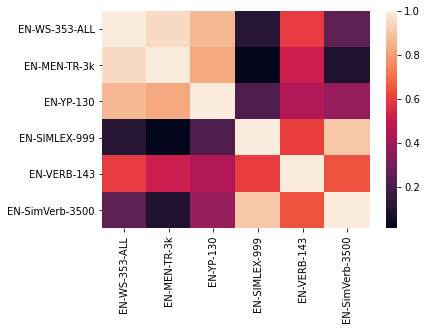

In [ ]:
# !pip install seaborn
# import seaborn as sns
# %matplotlib inline
# sns.heatmap(relatedness_result.corr(), annot=False)

In [ ]:
final_result[['algorithm', 'dimension', 'window', 'method', 'model_type']] = final_result['model_name'].str.split("_", expand=True)

,0,1,2,3,4
0,word2vec,size=100,window=50,sg=0,IN-IN
1,word2vec,size=100,window=50,sg=0,IN-OUT
2,word2vec,size=100,window=50,sg=0,OUT-IN
3,word2vec,size=100,window=50,sg=0,OUT-OUT
4,word2vec,size=100,window=5,sg=1,IN-IN
5,word2vec,size=100,window=5,sg=1,IN-OUT
6,word2vec,size=100,window=5,sg=1,OUT-IN
7,word2vec,size=100,window=5,sg=1,OUT-OUT
8,word2vec,size=300,window=5,sg=1,IN-IN
9,word2vec,size=300,window=5,sg=1,IN-OUT


## Appendix

In [ ]:
!pip install colabcode

     |████████████████████████████████| 829 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 13.6 MB/s eta 0:00:01
  Created wheel for pyngrok: filename=pyngrok-4.1.12-py3-none-any.whl size=16808 sha256=9aaf8aaa414f24a441f7e518f244ac9d268f7806d27e944dda9d07953c329aef
  Stored in directory: /home/jovyan/.cache/pip/wheels/c5/e6/f4/ed442f176b61127deccd76cf0d7615e13d99ec6b162dd36f5d
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=0dc886b43a8e680be6ff0f11781d2628ed0c812c49a76c3a535b59b112492560
  Stored in directory: /home/jovyan/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=7dde14d9186a732c97d0b920f455d52bcfb918fd6e08b0f2c0cb9c32778c4e95
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyngrok future PyYAML
You should con

In [ ]:
from colabcode import ColabCode
ColabCode(port=10000, password="mohit")

Code Server can be accessed on: https://dd467acbbfba.ngrok.io                                       
[2020-09-13T08:13:42.784Z] info  Using config file ~/.config/code-server/config.yaml
[2020-09-13T08:13:43.233Z] info  Using user-data-dir ~/.local/share/code-server
[2020-09-13T08:13:43.245Z] info  code-server 3.5.0 de41646fc402b968ca6d555fdf2da7de9554d28a
[2020-09-13T08:13:43.251Z] info  HTTP server listening on http://127.0.0.1:10000
[2020-09-13T08:13:43.252Z] info      - Using password from $PASSWORD
[2020-09-13T08:13:43.252Z] info      - To disable use `--auth none`
[2020-09-13T08:13:43.252Z] info    - Not serving HTTPS


KeyboardInterrupt: 